In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

from io_data import loadSpatialDataset
from analyze import calcUmap, plotUmap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, linear_model
import random
from tqdm import tqdm
import re
import seaborn as sns

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")

# Like colorblind_palette[4] for control, colorblind_palette[0] for test

In [3]:
def calcUmap(adata, nr_latent_dims: int = 15, n_neighbors: int = 25):
    ''' Calculate neighbourhood graph + umap
    '''
    sc.tl.pca(adata, svd_solver='arpack', n_comps=nr_latent_dims - 1)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=nr_latent_dims)
    sc.tl.umap(adata)
    return adata

def plotUmap(adata, color: str, out_file: str = None, title: str = "", pattern_to_alpha: str = None, s: int =16, legend_fontsize: int = 20):
    """ Plot UMAP with a specified color in the .obs columns.


    Parameters
    ----------
    color : str
        color
    out_file : str
        out_file
    pattern_to_alpha : str
        pattern_to_alpha
    s : int
        Dotsize
    """
    if pattern_to_alpha is not None:
        alpha_list = [1 if pattern == pattern_to_alpha else 0.2 for pattern in adata.obs["pattern"]]
    else:
        alpha_list = None
    fig = sc.pl.umap(adata, color=color, title=title, s=s, alpha=alpha_list, legend_fontsize = legend_fontsize, return_fig = True)
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)

In [4]:
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [4]:
adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [86]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
choices = ['Low', 'Intermediate', 'Strong']
for adata in [adata_split_cellID]:
    conditions = [
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [12]:
calcUmap(adata_split_cellID)

AnnData object with n_obs × n_vars = 1627152 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    uns: 'test_cellIDs', 'train_cellIDs', 'pca', 'neighbors', 'umap'
    obsm: 'latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [93]:
import pickle

path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/calcUmap_adata_split_cellID.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(adata_split_cellID, f)

In [4]:
import pickle
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/calcUmap_adata_split_cellID.pkl"

with open(path, 'rb') as p:
    adata_split_cellID = pickle.load(p)

low_spots/low_strength/pericellular combo to convince me that it is more distinct from 
low_strength/low_spots/random than 
high_spots/low_strength/pericellular is from 
high_spots/low_strength/random

In [17]:
import numpy as np

# Define the conditions
conditions = [
    (adata_split_cellID.obs['pattern_strength'] == 'Low') & (adata_split_cellID.obs['pattern'] == 'pericellular') & (adata_split_cellID.obs['n_spots_interval'].isin(['0-10'])),
    (adata_split_cellID.obs['pattern'] == 'random') & (adata_split_cellID.obs['n_spots_interval'] == '0-10'),
    (adata_split_cellID.obs['pattern_strength'] == 'Low') & (adata_split_cellID.obs['pattern'] == 'pericellular') & (adata_split_cellID.obs['n_spots_interval'].isin(['100+'])),
    (adata_split_cellID.obs['pattern'] == 'random') & (adata_split_cellID.obs['n_spots_interval'] == '100+')
]

# Define the choices
choices = ['Pericellular - Low Counts', 'Non-pattern - Low Counts', 'Pericellular - High Counts', 'Non-pattern - High Counts']

# Create the new column
adata_split_cellID.obs['low_counts'] = np.select(conditions, choices, default='Other')

In [18]:
adata_split_cellID.obs['low_counts'].value_counts()

low_counts
Other                         1511592
Non-pattern - High Counts       78722
Pericellular - High Counts      26288
Non-pattern - Low Counts         8037
Pericellular - Low Counts        2513
Name: count, dtype: int64

In [15]:
import numpy as np

# Define the conditions
conditions = [

]

# Define the choices
choices = ['Pericellular', 'Non-pattern']

# Create the new column
adata_split_cellID.obs['high_counts'] = np.select(conditions, choices, default='Other')

In [16]:
adata_split_cellID.obs['high_counts'].value_counts()

high_counts
Other           1522142
Non-pattern       78722
Pericellular      26288
Name: count, dtype: int64

In [7]:
lowspot_lowstrength_pericellular = adata_split_cellID[(adata_split_cellID.obs['pattern_strength'] == 'Low') & (adata_split_cellID.obs['pattern'] == 'pericellular')& (adata_split_cellID.obs['n_spots_interval'] == '0-10')]
highspot_lowstrength_pericellular = adata_split_cellID[(adata_split_cellID.obs['pattern_strength'] == 'Low') & (adata_split_cellID.obs['pattern'] == 'pericellular')& (adata_split_cellID.obs['n_spots_interval'] == '100+')]
lowspot_random = adata_split_cellID[(adata_split_cellID.obs['pattern'] == 'random') & (adata_split_cellID.obs['n_spots_interval'] == '0-10')]
highspot_random = adata_split_cellID[(adata_split_cellID.obs['pattern'] == 'random') & (adata_split_cellID.obs['n_spots_interval'] == '100+')]

View of AnnData object with n_obs × n_vars = 2513 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'test_cellIDs', 'train_cellIDs', 'pca', 'neighbors', 'umap', 'pattern_colors', 'cell_id_colors', 'pattern_strength_colors'
    obsm: 'latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

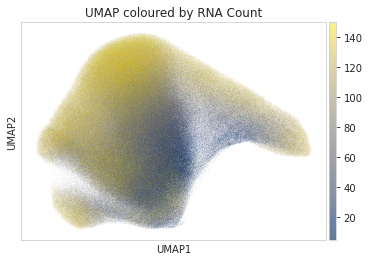

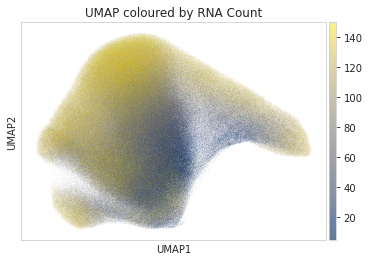

In [13]:
sc.pl.umap(adata_split_cellID, color="n_spots", title="UMAP coloured by RNA Count", cmap='cividis', alpha=0.6, s=0.2, legend_fontsize = 13, return_fig = True)

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


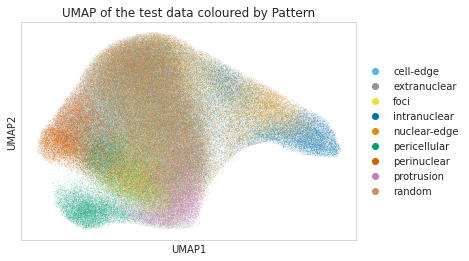

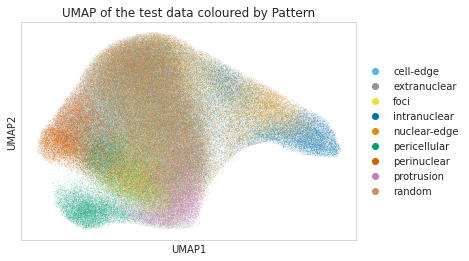

In [50]:
sc.pl.umap(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])], color="pattern", title="UMAP of the test data coloured by Pattern", alpha=0.5, palette=new_palette, s=1, legend_fontsize = 10, return_fig = True)

In [24]:
colorblind_palette = sns.color_palette("colorblind")
color_dict = {
    'Other': colorblind_palette[7],
    'Pericellular - Low Counts': colorblind_palette[0],
    'Non-pattern - Low Counts': colorblind_palette[4],
    'Pericellular - High Counts': colorblind_palette[2],
    'Non-pattern - High Counts': colorblind_palette[8]
}

# Create a dictionary for alphas
alpha_dict = {
    'Other': 0.1,
    'Pericellular - Low Counts': 0.5,
    'Non-pattern - Low Counts': 0.5,
    'Pericellular - High Counts': 0.5,
    'Non-pattern - High Counts': 0.5
}



In [26]:
adata_split_cellID.obs['low_counts'].unique()

['Other', 'Pericellular - High Counts', 'Pericellular - Low Counts', 'Non-pattern - High Counts', 'Non-pattern - Low Counts']
Categories (5, object): ['Non-pattern - High Counts', 'Non-pattern - Low Counts', 'Other', 'Pericellular - High Counts', 'Pericellular - Low Counts']

In [40]:
color_dict = {
    'Other': colorblind_palette[7],
    'Pericellular - Low Counts': colorblind_palette[0],
    'Non-pattern - Low Counts': colorblind_palette[8],
    'Pericellular - High Counts': colorblind_palette[2],
    'Non-pattern - High Counts': colorblind_palette[4]
}

alpha_dict = {
    'Other': 0.2,
    'Pericellular - Low Counts': 0.5,
    'Non-pattern - Low Counts': 0.4,
    'Pericellular - High Counts': 0.5,
    'Non-pattern - High Counts': 0.4
}


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/sit

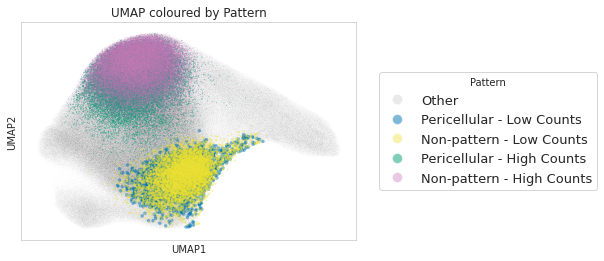

In [41]:

# Plot the UMAP
fig, ax = plt.subplots()

# Plot each group with its respective color and alpha
for label in adata_split_cellID.obs['low_counts'].unique():
    subset = adata_split_cellID[adata_split_cellID.obs['low_counts'] == label]
    sc.pl.umap(subset, color='low_counts', title='UMAP coloured by Pattern', 
               ax=ax, show=False, legend_loc=None,
               alpha=alpha_dict[label], palette=[color_dict[label]])

# Add the legend manually
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], 
                      markersize=10, alpha=alpha_dict[label], label=label) 
           for label in color_dict.keys()]
ax.legend(handles=handles, fontsize=13, title="Pattern", bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.show()

In [ ]:

# Plot the UMAP with custom colors and alphas
fig, ax = plt.subplots()
sc.pl.umap(adata_split_cellID, color='low_counts', title='UMAP coloured by Pattern', ax=ax, show=False)

# Apply the custom alpha values
for collection, alpha in zip(ax.collections, adata_split_cellID.obs['alpha']):
    collection.set_alpha(alpha)

plt.show()


In [19]:
colorblind_palette = sns.color_palette("colorblind")
colorblind_palette[0], colorblind_palette[4], colorblind_palette[2], colorblind_palette[8], colorblind_palette[7]


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


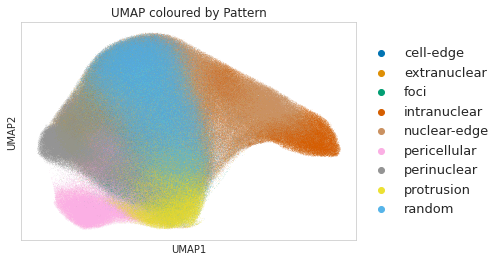

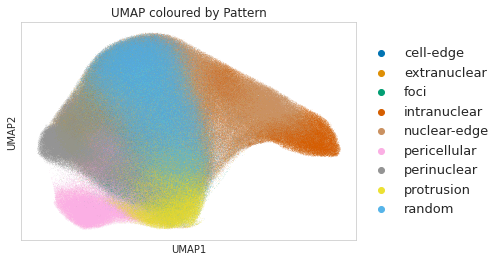

In [92]:
new_palette = colorblind_palette[:4] +colorblind_palette[5:]
sc.pl.umap(adata_split_cellID, color="pattern", title="UMAP coloured by Pattern", alpha=0.9, palette=new_palette, s=0.5, legend_fontsize = 13, return_fig = True)

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


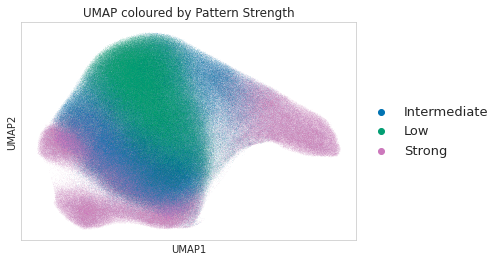

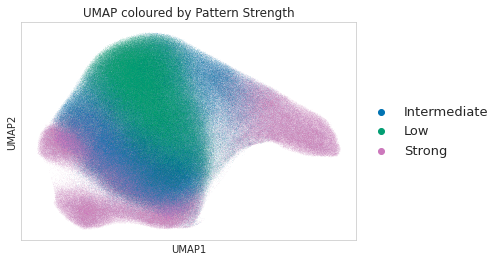

In [97]:
strength_palette = colorblind_palette[0:1] + colorblind_palette[2:3] + colorblind_palette[4:5]
sc.pl.umap(adata_split_cellID[adata_split_cellID.obs['pattern'] != 'random'], color="pattern_strength", title="UMAP coloured by Pattern Strength", alpha=0.9, palette=strength_palette, s=0.2, legend_fontsize = 13, return_fig = True)

In [ ]:
plotUmap(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['train_cellIDs'])], "pattern", title="UMAP of the train data coloured by Pattern")

In [15]:
import pickle
path = f"temp_objects/calcUmap_adata_mixed_cellID.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(adata_mixed_cellID, f)

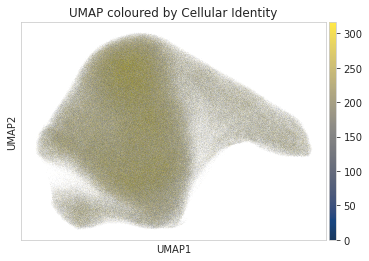

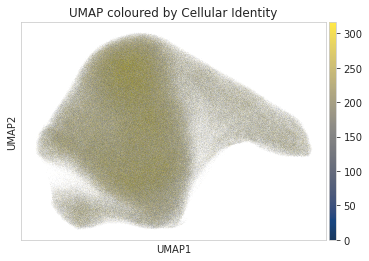

In [12]:
adata_split_cellID.obs['cell_id'] = adata_split_cellID.obs['cell_id'].astype(int)
sc.pl.umap(adata_split_cellID, color="cell_id", title="UMAP coloured by Cellular Identity", cmap='cividis', alpha=0.9, s=0.1, legend_fontsize = 13, return_fig = True)